# Project Setup

## TPU Preparation

In [1]:
import tensorflow as tf

D0926 00:02:11.319458782      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0926 00:02:11.319482948      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0926 00:02:11.319486279      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0926 00:02:11.319488880      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0926 00:02:11.319491388      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0926 00:02:11.319494884      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0926 00:02:11.319497444      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0926 00:02:11.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
except tf.errors.NotFoundError:
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

## Required Libraries

In [3]:
!pip install -q tf-models-official==2.12.0 emoji scikit-multilearn wordcloud

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treex 0.6.12 requires PyYAML>=6.0, but you have pyyaml 5.4.1 which is incompatible.
tensorboardx 2.6.1 requires protobuf>=4.22.3, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Basic libraries
import numpy as np
import pandas as pd
import re
from pathlib import Path

# Visualization tools
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Text and emoji processing
import tensorflow_text as text
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFlow and related add-ons
import tensorflow_hub as hub
import tensorflow_addons as tfa
from official.nlp import optimization

# Machine learning tools
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from skmultilearn.model_selection import iterative_train_test_split

/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Data Acquisition

## Loading the Dataset

In [5]:
ds_path = Path('/kaggle/input/goemotions/data/full_dataset')
dataframes = [pd.read_csv(file) for file in sorted(ds_path.glob('goemotions_*.csv'))]
df = pd.concat(dataframes, ignore_index=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

# Data Preprocessing

## Preparing the Dataset

In [7]:
# List of emotions we're keeping
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

# All the columns we're keeping
desired_columns = ['text', 'link_id', 'parent_id', 'rater_id', *emotions]

In [8]:
# Create a boolean mask to check if any of the emotion columns has a value of 1 for each row
mask = df[emotions].sum(axis=1) > 0

# Keep only the desired columns and the rows where at least one emotion is assigned
df = df.loc[mask, desired_columns].reset_index(drop=True)

In [9]:
# The function will assign 1 if there's at least one entry with a value of 1, otherwise 0
def aggregate_annotations(x):
    return (x.sum() > 0).astype(int)

# The function will assign 1 if at least half of the entries are 1, otherwise 0
def majority_vote(x):
    return (x.sum() >= len(x) / 2).astype(int)

def process_dataset(df, aggregation_function):
    # Apply the given aggregation function to each emotion column
    aggregations = {col: aggregation_function for col in emotions}
    
    # Group by the 'text' column and apply the aggregation functions
    df_processed = df.groupby(['text']).agg(aggregations).reset_index()

    # Keep only the rows where at least one emotion is assigned
    mask = df_processed[emotions].sum(axis=1) > 0
    return df_processed[mask].reset_index(drop=True)

In [10]:
df_agg = process_dataset(df, aggregate_annotations)
df_majority = process_dataset(df, majority_vote)

In [11]:
df = df_majority
df.tail()

,text,anger,disgust,fear,joy,sadness,surprise
21094,🤷🏻‍♀️ As a wise man once said: he was a bastar...,1,0,0,0,0,0
21095,🤷🏼‍♀️ I was wondering the same thing. It looke...,0,0,0,0,0,1
21096,🦀MY BABYS DEAD🦀,0,0,0,0,1,0
21097,🦀🦀🦀🦀🦀🦀🦀🦀🦀I’m bad at this game🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀🦀,0,0,0,0,1,0
21098,🧀 <——The best gold for you! 🙌,0,0,0,1,0,0


## Text Preprocessing

In [12]:
# Calculate the length of comment before preprocessing
df['old_length'] = df['text'].apply(len)

In [13]:
# Precompile regular expressions
EMOJIS = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
EMOJI_PATTERN = re.compile('|'.join(re.escape(u) for u in EMOJIS))
MULTI_EMOJI_PATTERN = re.compile(r"({})\1+".format(EMOJI_PATTERN.pattern))
REPEATED_CHAR_PATTERN = re.compile(r'(.)\1{2,}')

emoticon_dict = {
    ':)': '<smile_face>',
    ':-)': '<smile_face>',
    ':(': '<sad_face>',
    ':-(': '<sad_face>',
    ':D': '<big_smile>',
    ';)': '<wink>',
    ':-P': '<tongue_out>',
    ':/': '<unsure_face>',
    '<3': '<heart>',
    '¯_(ツ)_/¯': '<shrug>',
}


def preprocess_text(text):
    # Replace sequences of the same emoji with a single emoji
    text = MULTI_EMOJI_PATTERN.sub(r"\1", text)
    
    # Limit repeated characters to three repetitions
    text = REPEATED_CHAR_PATTERN.sub(r'\1\1\1', text)
    
    # Replace user mentions with a special token
    text = re.sub(r'u/\w+', '<user>', text)
    
    # Replace subreddit mentions with a special token    
#     text = re.sub(r'r/\w+', '<subreddit>', text)

    # Replace prices
    text = re.sub(r'\$\d{1,3}(,\d{3})*(\.\d+)?', '<PRICE>', text)
    
    # Replace times
    text = re.sub(r'\b\d{1,2}:\d{2}(:\d{2})?\b', '<TIME>', text)
    
    # Replace numbers except 1 or 2 digit integers
    text = re.sub(r'\d{1,3}(,\d{3})*(\.\d+)?|\d+(\.\d+)?', 
                  lambda m: '<NUM>' if len(m.group(0))>2 else m.group(0), text)
    
    for emoticon, name in emoticon_dict.items():
        text = text.replace(emoticon, name)
        
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()        
    
    return text

In [14]:
df['text'] = df['text'].apply(preprocess_text)

In [15]:
# Calculate the length of comment after preprocessing
df['new_length'] = df['text'].apply(len)

## Creating Train, Val, and Test sets

In [16]:
X = df[['text']]
y = df[emotions].copy()

In [17]:
def split_and_format(X_values, y_values, column_names, test_size=0.2):
    X_train, y_train, X_other, y_other = iterative_train_test_split(X_values, y_values, test_size=test_size)
    # Convert numpy arrays back to pandas DataFrame
    X_train_df = pd.Series(X_train.flatten(), name='text')
    y_train_df = pd.DataFrame(y_train, columns=column_names).astype('float32')
    X_other_df = pd.Series(X_other.flatten(), name='text')
    y_other_df = pd.DataFrame(y_other, columns=column_names).astype('float32')
    
    return X_train_df, y_train_df, X_other_df, y_other_df

In [18]:
np.random.seed(42)

X_train_all, y_train_all, X_test, y_test = split_and_format(X.values, y.values, test_size=0.2, column_names=y.columns)
X_train, y_train, X_val, y_val = split_and_format(X_train_all.values.reshape(-1,1), y_train_all.values, test_size=0.15, column_names=y.columns)

## Calculating Class Weights for Imbalance Handling

In [19]:
class_counts = tf.math.reduce_sum(y_train_all, axis=0)
total_count = tf.reduce_sum(class_counts)
class_weights = (1 / class_counts) * (total_count / len(class_counts))
class_weight_dict = {i: class_weights[i].numpy() for i in range(len(class_weights))}

In [20]:
pd.DataFrame([class_weights.numpy().round(2)], columns=y_train_all.columns, index=['Weight'])

,anger,disgust,fear,joy,sadness,surprise
Weight,0.77,1.16,2.12,0.72,0.92,1.12


# Data Inspection and Exploratory Analysis

## Label Distribution Visualization

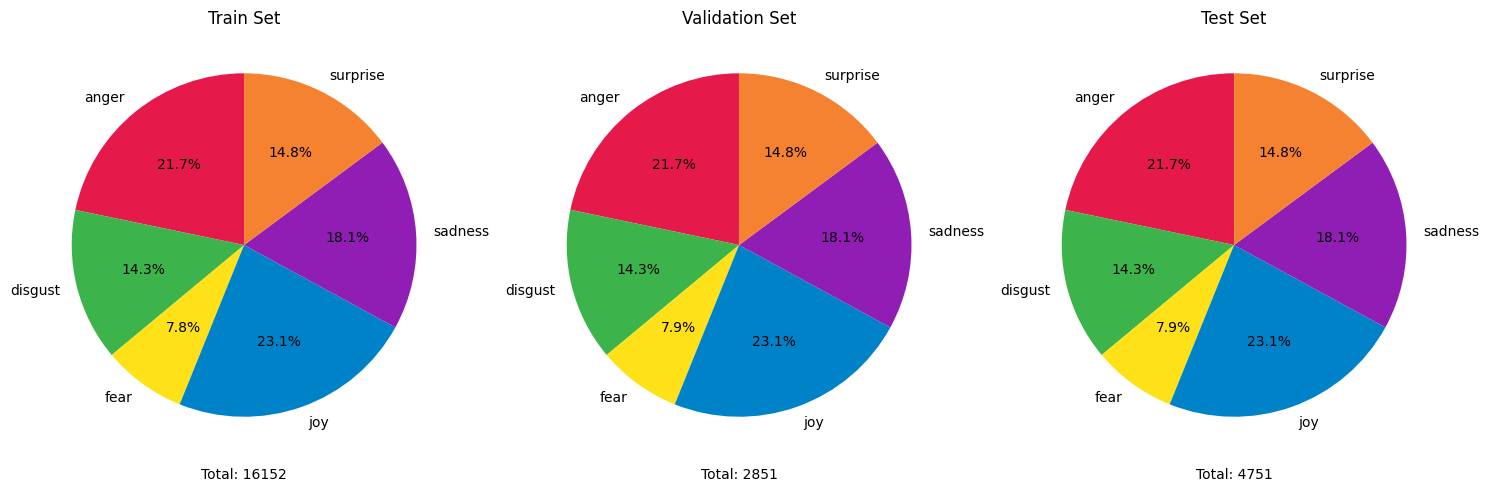

In [21]:
# Define a color map for each label
colors = {
    'anger': '#e6194b',  
    'disgust': '#3cb44b',
    'fear': '#ffe119',
    'joy': '#0082c8',
    'sadness': '#911eb4',
    'surprise': '#f58231',
}

# Function to compute label counts for multi-label data
def compute_label_counts(ds):
    return ds.sum(axis=0)

# Get the counts of each label in each set
train_counts = compute_label_counts(y_train)
val_counts = compute_label_counts(y_val)
test_counts = compute_label_counts(y_test)

# Generate the pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    (train_counts, "Train Set"),
    (val_counts, "Validation Set"),
    (test_counts, "Test Set")
]

for i, (counts, title) in enumerate(datasets):
    labels = counts.index
    sizes = counts.values
    colors_list = [colors[label] for label in labels]
    axs[i].pie(sizes, labels=labels, colors=colors_list, autopct='%1.1f%%', startangle=90)
    axs[i].axis('equal')
    axs[i].set_title(title)
    axs[i].text(0.5, -0.05, f'Total: {int(sum(sizes))}', size=10, ha='center', transform=axs[i].transAxes)

plt.tight_layout()
plt.show()

## Comment Lengths Before and After Preprocessing

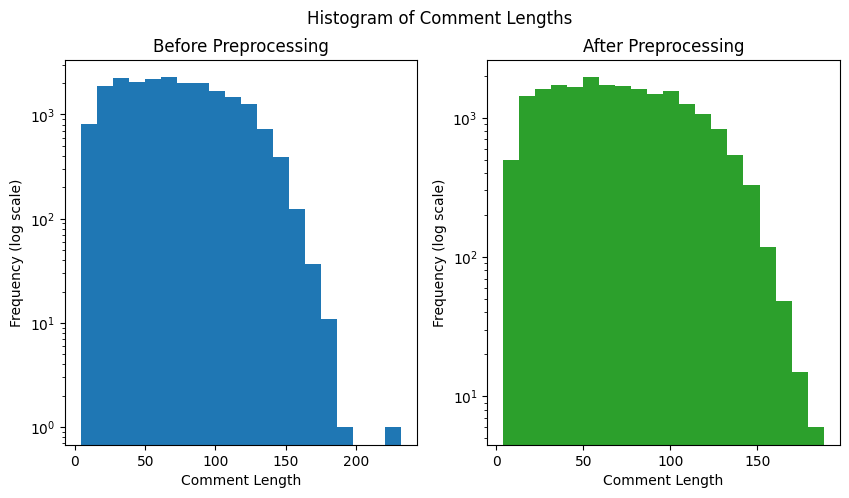

In [22]:
columns = ['old_length', 'new_length']
titles = ['Before Preprocessing', 'After Preprocessing']
colors = ['tab:blue', 'tab:green']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Iterate over the columns and subplots
for col, title, color, ax in zip(columns, titles, colors, axs):
    # Plot a histogram of the tweet lengths
    ax.hist(df[col], bins=20, color=color)

    # Set labels and title
    ax.set_xlabel('Comment Length')
    ax.set_ylabel('Frequency (log scale)')
    ax.set_title(title)

    # Set y-axis to log scale
    ax.set_yscale('log')

fig.suptitle('Histogram of Comment Lengths')

plt.show()

## Word Clouds

In [23]:
stopwords = set(STOPWORDS)
other_words = ['Name', 'num', 'people', 'really', 'today', 'tomorrow', 'tonight', 'night', 'day', 'go', 'will', 
               's', 'may', 'see','come', 'going', 'game', '1st', '2nd', '3rd', '4th', 'Im', 'one', 'time', 'hate',
               'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'watch', 'make', 'thing',
              'still', 'yeah']
stopwords.update(other_words)

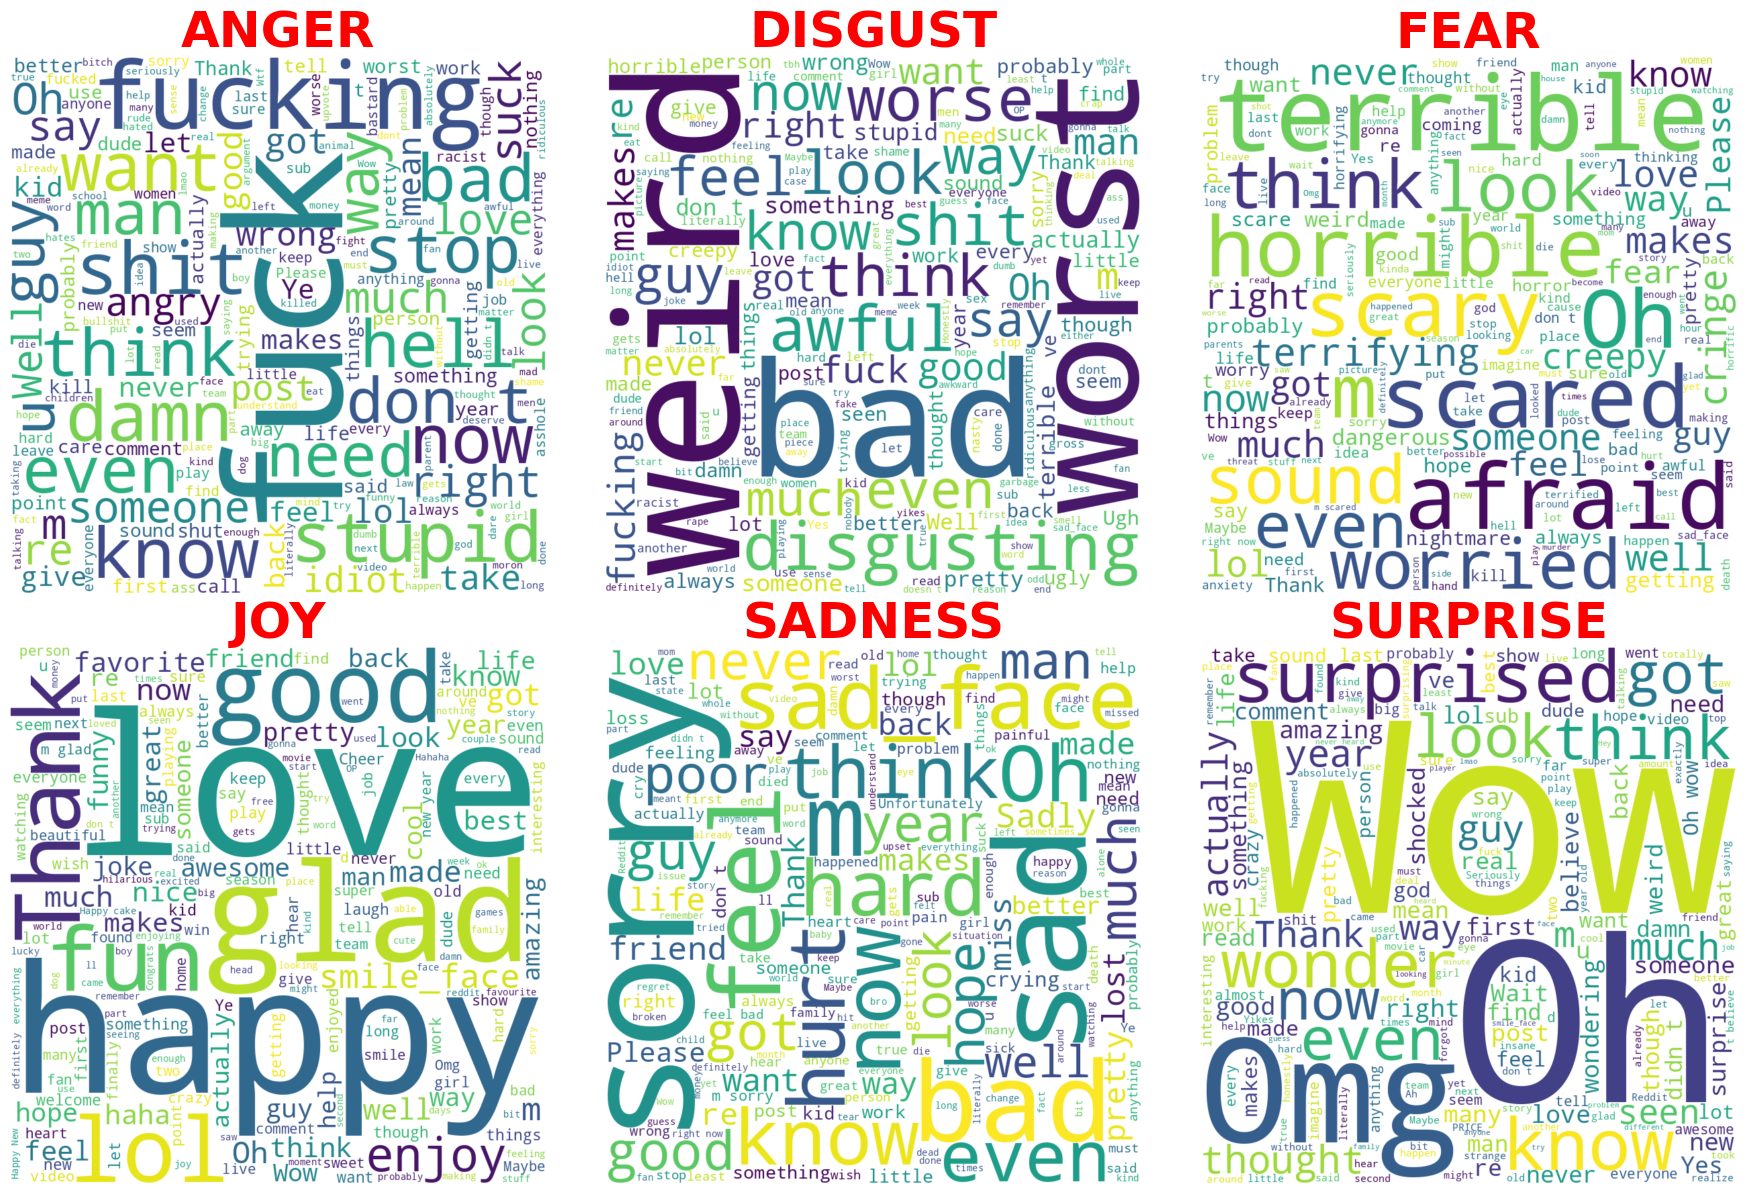

In [24]:
df_train_all = pd.concat([X_train_all, y_train_all], axis=1)

# Given the multi-label nature, we need to iterate over each emotion column to get the text associated with it.
emotions = y_train_all.columns 

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid of plots

for i, emotion in enumerate(emotions):
    ax = axes[i//3, i%3]
    
    # Filter out comments with the current emotion label
    emotion_comments = df_train_all[df_train_all[emotion] == 1]['text']
    
    # Concatenate all comments for the current emotion
    all_text = ' '.join(emotion_comments)
    
    # Generate word cloud
    wordcloud = WordCloud(stopwords=stopwords, width=800, height=800, 
                          background_color='white', min_font_size=10).generate(all_text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(emotion.upper(), fontsize=36, color='red', fontweight='bold')

plt.tight_layout()
plt.show() 

## Box Plot

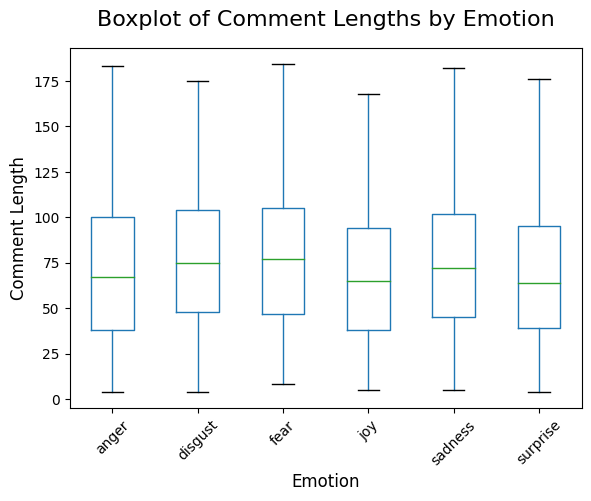

In [25]:
# Melt the DataFrame to long format
melted_df = df.melt(id_vars=['text', 'new_length'], 
                    value_vars=emotions, 
                    var_name='emotion', 
                    value_name='label_value')

# Filter rows where the label is 1
filtered_df = melted_df[melted_df['label_value'] == 1]

# Plot boxplot
ax = filtered_df.boxplot(column='new_length', by='emotion', grid=False, showfliers=False)

plt.suptitle('Boxplot of Comment Lengths by Emotion', fontsize=16)
plt.title('')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Comment Length', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# Baseline: Classic Machine Learning

## SVM

In [26]:
# Tokenization and TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_all)
X_test_vec = vectorizer.transform(X_test)

In [27]:
model = OneVsRestClassifier(SVC(kernel='linear', class_weight=class_weight_dict))
model.fit(X_train_vec, y_train_all)

OneVsRestClassifier(estimator=SVC(class_weight={0: 0.76724, 1: 1.162263,
                                                2: 2.1241896, 3: 0.7206295,
                                                4: 0.91908497, 5: 1.1239059},
                                  kernel='linear'))

In [28]:
# Predict and Evaluate
y_pred = model.predict(X_test_vec)
print("SVM Performance as a Baseline:")
print(classification_report(y_test, y_pred, target_names=y_test.columns))

SVM Performance as a Baseline:
              precision    recall  f1-score   support

       anger       0.69      0.57      0.62      1032
     disgust       0.74      0.26      0.38       681
        fear       0.78      0.44      0.57       373
         joy       0.81      0.70      0.75      1099
     sadness       0.75      0.51      0.61       861
    surprise       0.82      0.38      0.52       705

   micro avg       0.76      0.51      0.61      4751
   macro avg       0.77      0.48      0.58      4751
weighted avg       0.76      0.51      0.60      4751
 samples avg       0.54      0.53      0.53      4751



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Preparing for Deep Learning

## Dataset Preparation for TensorFlow

In [29]:
def prepare_dataset(X, y, preprocessor, batch_size=32, shuffle_buffer=None):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle_buffer:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x,y: (preprocessor(x), y))
    ds = ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

## Utility Functions for BERT-based Models

In [30]:
def get_handles(model_type):
    urls = {
        'bert': {
            'model': 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-24-h-1024-a-16/versions/4',
            'preprocessor': "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
        },
        'roberta': {
            'model': 'https://www.kaggle.com/models/kaggle/roberta/frameworks/TensorFlow2/variations/en-cased-l-24-h-1024-a-16/versions/1',
            'preprocessor': "https://kaggle.com/models/kaggle/roberta/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/1"
        },
        'electra': {
            'model': 'https://www.kaggle.com/models/google/electra/frameworks/TensorFlow2/variations/large/versions/2',
            'preprocessor': "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
        }
    }
    
    if model_type not in urls:
        raise ValueError(f"Unsupported model_type: {model_type}")

    return urls[model_type]


In [31]:
def build_preprocessor(model_type='bert'):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor = hub.load(get_handles(model_type)['preprocessor'])
    tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenize(text_input)]
    bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, 
                                      arguments=dict(seq_length=185),
                                      name=f'{model_type}_input_packer')
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    return tf.keras.Model(text_input, encoder_inputs)

In [32]:
def build_classifier_model(num_classes, model_type='bert', dropout_rate=0.1, trainable=True):

    class Classifier(tf.keras.Model):
        def __init__(self, num_classes, model_type):
            super(Classifier, self).__init__(name="prediction")
            self.encoder = hub.KerasLayer(get_handles(model_type)['model'], trainable=trainable)
            self.dropout = tf.keras.layers.Dropout(dropout_rate)
            self.dense = tf.keras.layers.Dense(num_classes)

        def call(self, preprocessed_text):
            encoder_outputs = self.encoder(preprocessed_text)
            pooled_output = encoder_outputs["pooled_output"]
            x = self.dropout(pooled_output)
            x = self.dense(x)
            return x

    model = Classifier(num_classes, model_type)
    return model

## Other Utility Funcitons and Tools

### Visualization: Training History Plotter

In [33]:
def plot_training_history(history, title=None):
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    # Set the integer ticks for the epoch axis
    for ax in axs.flatten():
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Plot the training and validation accuracy
    epochs = range(1, len(history.history['weighted_F1']) + 1)
    axs[0].plot(epochs, history.history['weighted_F1'], label='Training F1-Score (Weighted)')
    axs[0].plot(epochs, history.history['val_weighted_F1'], label='Validation F1-Score (Weighted)')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('F1-Score (Weighted)')
    axs[0].legend()

    # Plot the training and validation loss
    axs[1].plot(epochs, history.history['loss'], label='Training Loss')
    axs[1].plot(epochs, history.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    if title:
        fig.suptitle(title, fontsize=16)
        
    plt.tight_layout()
    plt.show()

### Custom F1 Score Metric (Logit-Aware)

In [34]:
class CustomF1Score(tfa.metrics.F1Score):
    def __init__(self, *args, from_logits=False, **kwargs):
        super(CustomF1Score, self).__init__(*args, **kwargs)
        self.from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Apply sigmoid to convert logits to probabilities if from_logits is True
        if self.from_logits:
            y_pred = tf.sigmoid(y_pred)
        
        # Continue with the usual update_state
        return super(CustomF1Score, self).update_state(y_true, y_pred, sample_weight)

### Optimizer Setup for BERT-Based Training

In [35]:
def build_optimizer(init_lr, batch_size, train_data_size, epochs, warmup_proportion=0.1, optimizer_type='adamw'):
    steps_per_epoch = train_data_size / batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(warmup_proportion * num_train_steps)

    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type=optimizer_type
    )
    
    return optimizer

### Training Callbacks

In [36]:
def get_callbacks(monitor='val_loss', patience=2, checkpoint_name='model_checkpoint', mode='auto'):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{checkpoint_name}.h5',
        monitor=monitor,
        save_best_only=True,
        save_weights_only=True,
        mode=mode,
    )

    earlystop_callback = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        # restore_best_weights=True,
        mode=mode,
    )
    
    return [checkpoint_callback, earlystop_callback]

# Training Deep Models

## Config

In [37]:
BATCH_SIZE = 32
epochs = 10

## BERT

In [38]:
model_preprocessor = build_preprocessor('bert')
train_all_ds_bert = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train_all))
train_ds_bert = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train))
val_ds_bert = prepare_dataset(X_val, y_val, model_preprocessor, BATCH_SIZE)
test_ds_bert = prepare_dataset(X_test, y_test, model_preprocessor, BATCH_SIZE)

In [39]:
with strategy.scope():
    # Custom Metric
    f1_score = CustomF1Score(from_logits=True, num_classes=6, average='weighted', threshold=0.5, name='weighted_F1')
    # Custom Optimizer
    optimizer = build_optimizer(init_lr=5e-6, batch_size=BATCH_SIZE, train_data_size=X_train.shape[0], epochs=epochs)
    # Model
    model = build_classifier_model(num_classes=6, model_type='bert', dropout_rate=0.1,)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[f1_score],
    )

In [40]:
callbacks = get_callbacks(patience=2, checkpoint_name='bert_checkpoint')

history = model.fit(
    train_ds_bert,
    epochs=epochs,
    validation_data=val_ds_bert,
    class_weight=class_weight_dict,
    callbacks=callbacks,
)

Epoch 1/10


2023-09-26 00:08:25.516834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
2023-09-26 00:08:27.497647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.


449/449 [==============================] - ETA: 0s - loss: 0.5232 - weighted_F1: 0.1256

2023-09-26 00:12:15.653326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-26 00:12:16.028829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


449/449 [==============================] - 305s 385ms/step - loss: 0.5232 - weighted_F1: 0.1256 - val_loss: 0.3970 - val_weighted_F1: 0.2793
Epoch 2/10
449/449 [==============================] - 82s 182ms/step - loss: 0.3232 - weighted_F1: 0.5693 - val_loss: 0.2717 - val_weighted_F1: 0.6609
Epoch 3/10
449/449 [==============================] - 81s 181ms/step - loss: 0.2577 - weighted_F1: 0.6956 - val_loss: 0.2622 - val_weighted_F1: 0.6916
Epoch 4/10
449/449 [==============================] - 78s 174ms/step - loss: 0.2305 - weighted_F1: 0.7362 - val_loss: 0.2647 - val_weighted_F1: 0.6973
Epoch 5/10
449/449 [==============================] - 79s 176ms/step - loss: 0.2071 - weighted_F1: 0.7693 - val_loss: 0.2712 - val_weighted_F1: 0.6969


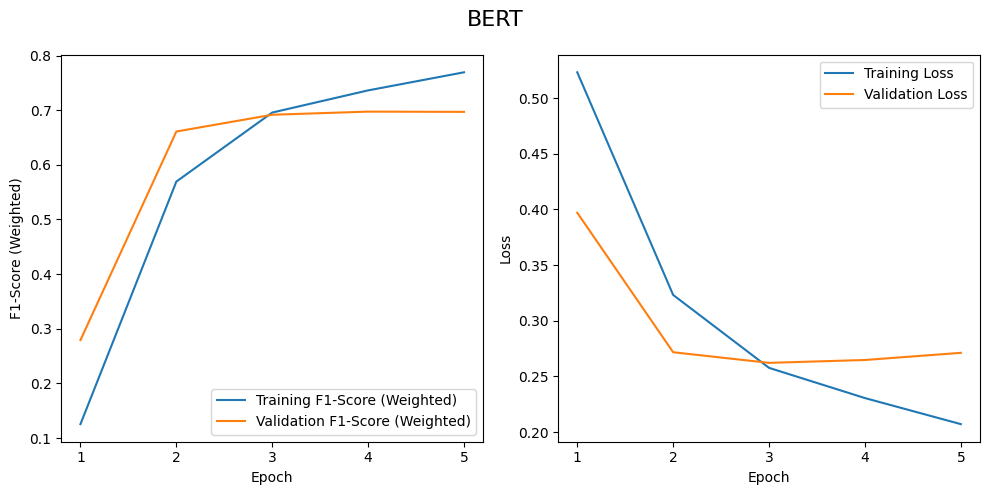

In [41]:
plot_training_history(history, title='BERT')

## RoBERTa

In [42]:
model_preprocessor = build_preprocessor('roberta')
train_all_ds_roberta = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train_all))
train_ds_roberta = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train))
val_ds_roberta = prepare_dataset(X_val, y_val, model_preprocessor, BATCH_SIZE)
test_ds_roberta = prepare_dataset(X_test, y_test, model_preprocessor, BATCH_SIZE)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [43]:
with strategy.scope():
    # Custom Metric
    f1_score = CustomF1Score(from_logits=True, num_classes=6, average='weighted', threshold=0.5, name='weighted_F1')
    # Custom Optimizer
    optimizer = build_optimizer(init_lr=5e-6, batch_size=BATCH_SIZE, train_data_size=X_train.shape[0], epochs=epochs)
    # Model
    model = build_classifier_model(num_classes=6, model_type='roberta', dropout_rate=0.1,)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[f1_score],
    )

In [44]:
callbacks = get_callbacks(patience=2, checkpoint_name='roberta_checkpoint')

history = model.fit(
    train_ds_roberta,
    epochs=epochs,
    validation_data=val_ds_roberta,
    class_weight=class_weight_dict,
    callbacks=callbacks,
)

Epoch 1/10


2023-09-26 00:19:36.614628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
2023-09-26 00:19:38.598940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.


449/449 [==============================] - ETA: 0s - loss: 0.4891 - weighted_F1: 0.2239

2023-09-26 00:23:40.962621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-26 00:23:41.321773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


449/449 [==============================] - 322s 422ms/step - loss: 0.4891 - weighted_F1: 0.2239 - val_loss: 0.3157 - val_weighted_F1: 0.5925
Epoch 2/10
449/449 [==============================] - 90s 200ms/step - loss: 0.2908 - weighted_F1: 0.6615 - val_loss: 0.2677 - val_weighted_F1: 0.6941
Epoch 3/10
449/449 [==============================] - 90s 200ms/step - loss: 0.2548 - weighted_F1: 0.7133 - val_loss: 0.2674 - val_weighted_F1: 0.6990
Epoch 4/10
449/449 [==============================] - 89s 197ms/step - loss: 0.2335 - weighted_F1: 0.7439 - val_loss: 0.2692 - val_weighted_F1: 0.7006
Epoch 5/10
449/449 [==============================] - 86s 192ms/step - loss: 0.2152 - weighted_F1: 0.7658 - val_loss: 0.2773 - val_weighted_F1: 0.7008


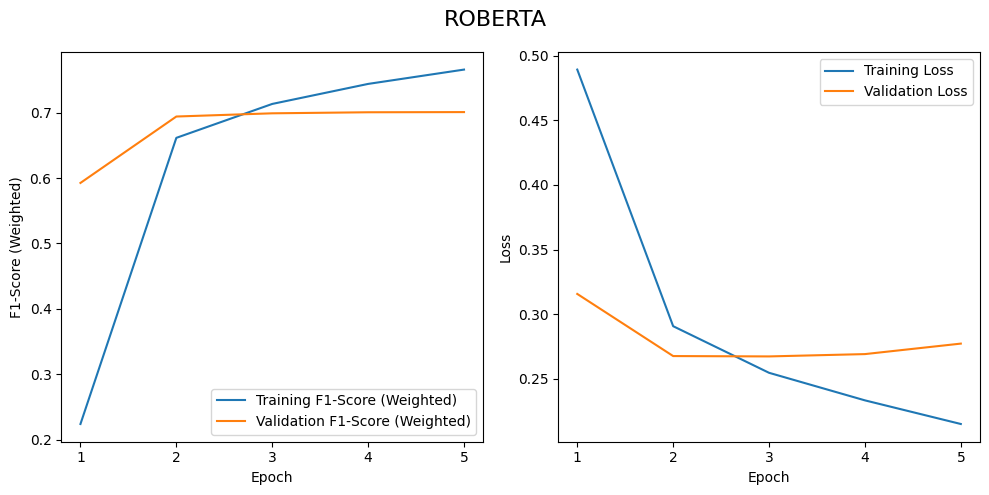

In [45]:
plot_training_history(history, title='ROBERTA')

## ELECTRA

In [46]:
model_preprocessor = build_preprocessor('electra')
train_all_ds_electra = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train_all))
train_ds_electra = prepare_dataset(X_train, y_train, model_preprocessor, BATCH_SIZE, len(X_train))
val_ds_electra = prepare_dataset(X_val, y_val, model_preprocessor, BATCH_SIZE)
test_ds_electra = prepare_dataset(X_test, y_test, model_preprocessor, BATCH_SIZE)

In [47]:
with strategy.scope():
    # Custom Metric
    f1_score = CustomF1Score(from_logits=True, num_classes=6, average='weighted', threshold=0.5, name='weighted_F1')
    # Custom Optimizer
    optimizer = build_optimizer(init_lr=1e-5, batch_size=BATCH_SIZE, train_data_size=X_train.shape[0], epochs=epochs)
    # Model
    model = build_classifier_model(num_classes=6, model_type='electra', dropout_rate=0.1,)
    model.compile(
        optimizer=optimizer,
#         loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#         weighted_metrics=['accuracy'],
        metrics=[f1_score],
    )

In [48]:
callbacks = get_callbacks(patience=2, checkpoint_name='electra_checkpoint')

history = model.fit(
    train_ds_electra,
    epochs=epochs,
    validation_data=val_ds_electra,
    class_weight=class_weight_dict,
    callbacks=callbacks,
)

Epoch 1/10


2023-09-26 00:31:42.172764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
2023-09-26 00:31:44.389364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.


449/449 [==============================] - ETA: 0s - loss: 0.4990 - weighted_F1: 0.0907

2023-09-26 00:35:36.761541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-26 00:35:37.244759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


449/449 [==============================] - 315s 397ms/step - loss: 0.4990 - weighted_F1: 0.0907 - val_loss: 0.4925 - val_weighted_F1: 0.0014
Epoch 2/10
449/449 [==============================] - 83s 186ms/step - loss: 0.4784 - weighted_F1: 0.0095 - val_loss: 0.3953 - val_weighted_F1: 0.2755
Epoch 3/10
449/449 [==============================] - 83s 184ms/step - loss: 0.3099 - weighted_F1: 0.6135 - val_loss: 0.2589 - val_weighted_F1: 0.6996
Epoch 4/10
449/449 [==============================] - 79s 177ms/step - loss: 0.2452 - weighted_F1: 0.7220 - val_loss: 0.2619 - val_weighted_F1: 0.7040
Epoch 5/10
449/449 [==============================] - 79s 177ms/step - loss: 0.2095 - weighted_F1: 0.7714 - val_loss: 0.2761 - val_weighted_F1: 0.7036


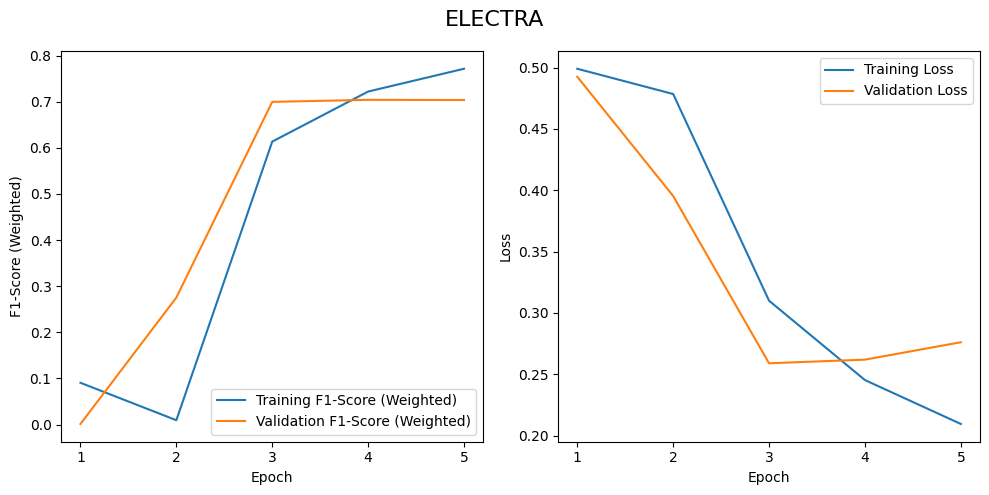

In [49]:
plot_training_history(history, title='ELECTRA')

# Final Model Selection and Evaluation

## Final Training with Best Model on Combined Training + Validation Data

In [50]:
epochs = 4

In [51]:
with strategy.scope():
    f1_score = CustomF1Score(from_logits=True, num_classes=6, average='weighted', threshold=0.5, name='weighted_F1')
    optimizer = build_optimizer(init_lr=5e-6, batch_size=BATCH_SIZE, train_data_size=X_train_all.shape[0], epochs=epochs)
    # Model
    model = build_classifier_model(num_classes=6, model_type='roberta', dropout_rate=0.1,)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[f1_score],
    )

In [52]:
history = model.fit(
    train_all_ds_roberta,
    epochs=epochs,
    class_weight=class_weight_dict,
)

Epoch 1/4


2023-09-26 00:42:49.092563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.
2023-09-26 00:42:51.146493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamWeightDecay/AdamWeightDecay/AssignAddVariableOp.


449/449 [==============================] - 278s 338ms/step - loss: 0.4355 - weighted_F1: 0.3535
Epoch 2/4
449/449 [==============================] - 78s 174ms/step - loss: 0.2752 - weighted_F1: 0.6827
Epoch 3/4
449/449 [==============================] - 78s 175ms/step - loss: 0.2497 - weighted_F1: 0.7211
Epoch 4/4
449/449 [==============================] - 79s 175ms/step - loss: 0.2349 - weighted_F1: 0.7405


## Evaluating the Final Model

In [53]:
model.evaluate(test_ds_roberta)

2023-09-26 00:50:52.437794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-26 00:50:52.800888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


133/133 [==============================] - 38s 118ms/step - loss: 0.2774 - weighted_F1: 0.6956


[0.27739036083221436, 0.6955763101577759]

In [54]:
y_pred = model.predict(test_ds_roberta)
y_pred = tf.sigmoid(y_pred).numpy()
y_pred_binary = (y_pred >= 0.5).astype(int)

2023-09-26 00:51:27.807775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-26 00:51:28.207293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


133/133 [==============================] - 34s 116ms/step


In [55]:
report = classification_report(y_test, 
                               y_pred_binary, 
                               target_names=y_test.columns)

print(report)

              precision    recall  f1-score   support

       anger       0.70      0.71      0.70      1032
     disgust       0.63      0.43      0.51       681
        fear       0.70      0.54      0.61       373
         joy       0.85      0.82      0.84      1099
     sadness       0.76      0.66      0.71       861
    surprise       0.77      0.60      0.68       705

   micro avg       0.75      0.66      0.70      4751
   macro avg       0.73      0.63      0.67      4751
weighted avg       0.75      0.66      0.70      4751
 samples avg       0.71      0.69      0.69      4751



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Receiver Operating Characteristic

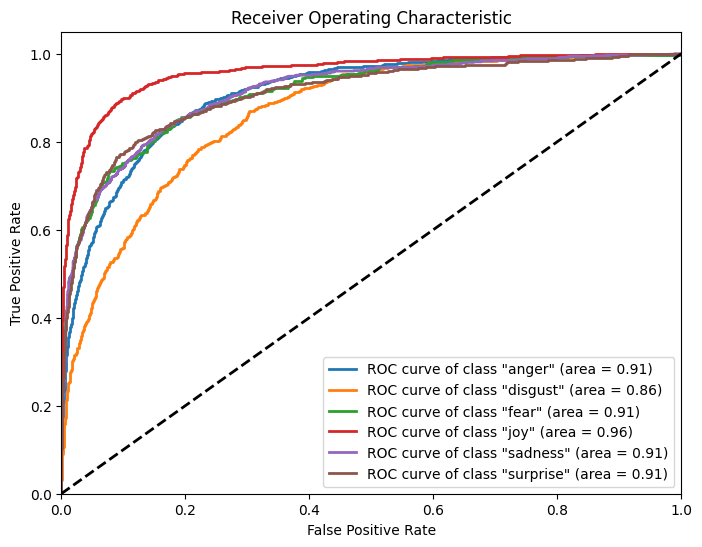

In [56]:
fpr = {}
tpr = {}
roc_auc = {}

num_classes = 6

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class "{emotions[i]}" (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()